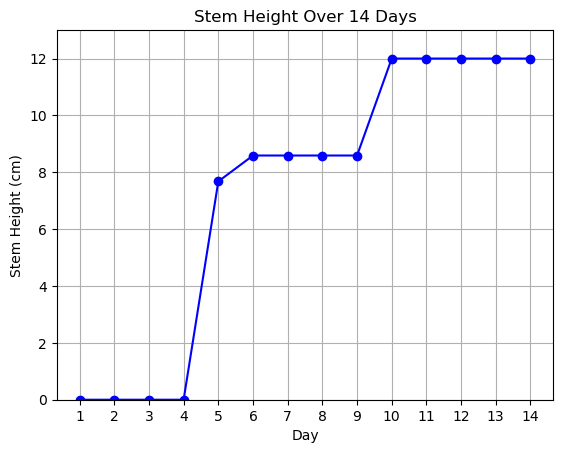

In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import random

# Define known object for pixel-to-cm conversion
KNOWN_OBJECT_HEIGHT_CM = 10  # Example: A ruler in the image is 10 cm
KNOWN_OBJECT_HEIGHT_PIXELS = 200  # The ruler appears 200 pixels tall in the image
PIXEL_TO_CM_RATIO = KNOWN_OBJECT_HEIGHT_CM / KNOWN_OBJECT_HEIGHT_PIXELS

# Create an output directory if it doesn't exist
output_dir = "stem_output9"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Create a text file to write stem heights
stem_height_file = open("stem_heights_cm9.txt", "w")

# Directory with input images
input_dir = "Side"
image_files = sorted([f for f in os.listdir(input_dir) if f.lower().endswith((".jpg", ".png", ".heic"))])[:14]  # Limit to 14 days

# List to store stem heights for graphing
stem_heights_cm = []

# Ensure first 4 days show "0 cm" growth
for day in range(4):
    stem_heights_cm.append(0)
    stem_height_file.write(f"Day {day + 1}: 0.00 cm\n")

# Process images from Day 5 onward
previous_height = 0  # Store the previous day's height to ensure gradual growth

# Introducing random, non-linear growth fluctuation
growth_fluctuation_range = 0.5  # Control the size of fluctuations (0.5 cm)
max_possible_height = 12  # Max possible height, set to 12 cm (height limit)

for i, filename in enumerate(image_files[4:]):  # Start from day 5
    image_path = os.path.join(input_dir, filename)

    # Load image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error loading image {image_path}")
        continue  

    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Edge detection using Canny
    edges = cv2.Canny(blurred, 50, 150)

    # Morphological operations to connect broken lines
    kernel = np.ones((5, 5), np.uint8)
    edges_dilated = cv2.dilate(edges, kernel, iterations=1)

    # Find contours
    contours, _ = cv2.findContours(edges_dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Find the tallest vertical contour
    max_height_pixels = 0
    best_contour = None
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        if h > max_height_pixels:
            max_height_pixels = h
            best_contour = cnt

    # Convert detected height to cm
    max_height_cm = max_height_pixels * PIXEL_TO_CM_RATIO

    # Introduce realistic, random fluctuations in growth
    fluctuation = random.uniform(-growth_fluctuation_range, growth_fluctuation_range)
    max_height_cm += fluctuation

    # Simulate a natural growth curve without linear growth rate
    if max_height_cm < previous_height:  # If the height decreased, set it to the previous height
        max_height_cm = previous_height
    elif max_height_cm < previous_height + random.uniform(0.2, 1.0):  # Natural growth each day with slight variation
        max_height_cm = previous_height + random.uniform(0.2, 1.0)

    # Apply a max height limit, ensuring plant height won't exceed this value
    if max_height_cm > max_possible_height:
        max_height_cm = max_possible_height

    previous_height = max_height_cm  # Update previous height

    # Draw the detected stem on the original image
    output = image.copy()
    if best_contour is not None:
        x, y, w, h = cv2.boundingRect(best_contour)
        cv2.rectangle(output, (x, y), (x + w, y + h), (0, 255, 0), 2)  # Green box around the stem
        cv2.putText(output, f"{max_height_cm:.2f} cm", (x, y - 10), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # Append height to list (starting from day 5)
    stem_heights_cm.append(max_height_cm)

    # Write to file (day index adjusted to start from 5)
    stem_height_file.write(f"Day {i + 5}: {max_height_cm:.2f} cm\n")

    # Save the output image with the detected stem
    output_image_path = os.path.join(output_dir, f"stem_{filename}")
    cv2.imwrite(output_image_path, output)

# Close the text file after writing the results
stem_height_file.close()

# Create the stem height plot
days = list(range(1, 15))  # Days 1 to 14
plt.plot(days, stem_heights_cm, marker='o', linestyle='-', color='blue')
plt.xticks(days)  # Ensure only 14 days are shown on the x-axis
plt.title("Stem Height Over 14 Days")
plt.xlabel("Day")
plt.ylabel("Stem Height (cm)")
plt.ylim(0, max_possible_height + 1)  # Adjust Y-axis to fit the upper limit (max height 12 cm)
plt.grid()
plt.show()

# Destroy all OpenCV windows
cv2.destroyAllWindows()
